<a href="https://colab.research.google.com/github/Tarleton-Math/data-science-20-21/blob/master/data_science_20_21_notes_10_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Intro to Performance Metrics
## Class Notes 2020-10-13
## Data Science (masters)
## Math 5364 & 5366, Fall 20 & Spring 21
## Tarleton State University
## Dr. Scott Cook

In [ ]:
! pip install --upgrade numpy
! pip install --upgrade pandas

     |████████████████████████████████| 14.5MB 291kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


     |████████████████████████████████| 9.5MB 4.2MB/s 
  Found existing installation: pandas 1.1.2
    Uninstalling pandas-1.1.2:
      Successfully uninstalled pandas-1.1.2


Today we meet new more performance measures.  We'll use the Wisconsin Breast Cancer dataset.

Up to this point, we've evaluated our models using a confusion matrix and the accuracy.  Accuracy counts all errors as equally bad.  However, there are many cases when some errors are worse than others.  If so, we want our cross-validation and model selection/tuning processes to reflect that fact.

Consider the two types of errors for the Wisconsin Breast Cancer dataset
1. Classified as benign when actually malignant
2. Classified as malignant when actually benign

Type I errors are WAY worse.  The patient is unaware that they have cancer and, hence, do not seek treatment.  Type II is certainly undesirable and may lead to unnecessary medical treatment that carry their own risks.  Still, this is far better than leaving a cancer untreated.

This oberservation gave rise to a BUNCH of terms over the years.  [Here](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) is a nice summary.  [Here](https://scikit-learn.org/stable/modules/model_evaluation.html#) is the scikit learn module implementing there.

## Numeric scores

|   	 |     	   |   	     |
|:------:|:-------:|:-------:|
|Actual 0|true negative (TN)|false positive (FP)|
|Actual 1|false negative (FN)|true positive (TP)|
|   	 |Predict 0|Predict 1|


Divide by *ROW* sums

|   	 |     	   |   	     |
|:------:|:-------:|:-------:|
|Actual 0|specificity / selectivity / true negative rate (TNR)|fall out / false positive rate (FPR)|
|Actual 1|miss rate / false negative rate (FNR)|sensitivity / recall / hit rate / true positive rate (TPR)|
|   	 |Predict 0|Predict 1|

Divide by *COLUMN* sums

|   	 |     	   |   	     |
|:------:|:-------:|:-------:|
|Actual 0|negative predictive value (NPV)|false discovery rate (FDR)|
|Actual 1|false omission rate (FOR)|precision/positive predictive value (PPV)|
|   	 |Predict 0|Predict 1|


- def: accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$
- def: balanced accuracy = $\frac{TPR+TNR}{2}$
- def: $F_1=2*\frac{PPV \cdot TPR}{PPV + TPR}$ ([harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of precision and recall)
- def: $F_{\beta}=(1+\beta^2)*\frac{PPV \cdot TPR}{\beta^2 PPV + TPR}$ (makes TPR (recall) approximately $\beta$ times more important than precision
    - $\beta \to 0$, $F_{\beta} \to PPV$
    - $\beta \to \infty$, $F_{\beta} \to TPR$
There are more like this.

## Curves
- [Receiver-Operator Curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
- [Precision-Recall Curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)


Classfiers produce the predict_proba vector with the probabilities that an observation belong to each class. We are NOT forced to simply take the largest one as the prediction.  We can select a threshhold $p^*$ so that the classifier predicts class 1 iff predict_proba[1] > $p^*$.  We then vary $p^*$, computing precision, recall, specificity, etc  and plot them as a parametrized curve.

Let's make them by applying [GaussianNB](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) to the Wisconsin Breast Cancer data.





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

rng = np.random.RandomState(42)

data = load_breast_cancer()
# print(data.DESCR)
n, d = data.data.shape
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.Series(data.target)

holdout_frac = 0.30
holdout_splitter = StratifiedShuffleSplit(n_splits=1, test_size=holdout_frac, random_state=rng)
model_idx, holdout_idx = next(holdout_splitter.split(X, y))
X_m, y_m = X.iloc[model_idx]  , y.iloc[model_idx]
X_h, y_h = X.iloc[holdout_idx], y.iloc[holdout_idx]
X_m.shape, X_h.shape

def display_results(grid, cutoff=1.0):
    res = grid.cv_results_
    df = pd.DataFrame(res['params'])
    df['score'] = (res['mean_test_score'] * 100)
    mask = df['score'] >= df['score'].max() * min(1-cutoff, 1)
    with pd.option_context('display.max_rows', 100, 'precision', 2):
        display(df[mask].sort_values('score', ascending=False))
    return df

GaussianNB expected the features to be approximately normally distributed.  Let's check that by plotting for each feature:
- [Kernel density estimatation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation) - basically a smoothed curve version of a histogram
- [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) - Quantiles of data vs quantiles of perfect normal distribution.  Want to lie along line y=x.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mean radius


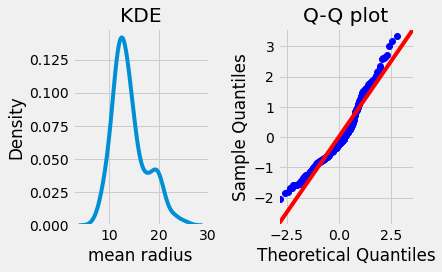

mean texture


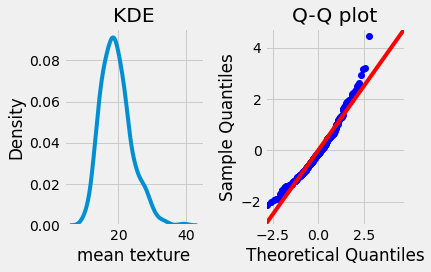

mean perimeter


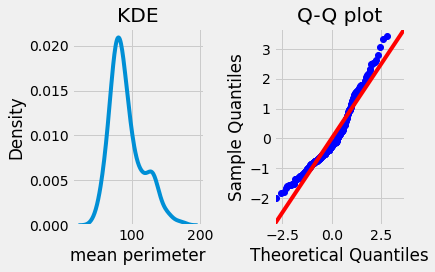

mean area


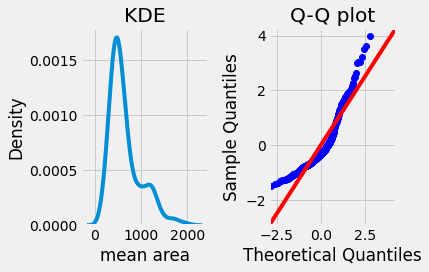

mean smoothness


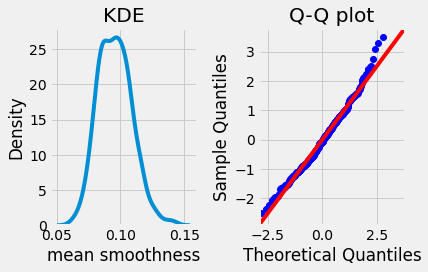

mean compactness


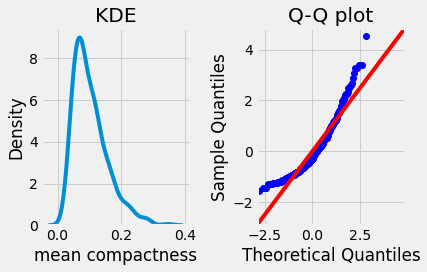

mean concavity


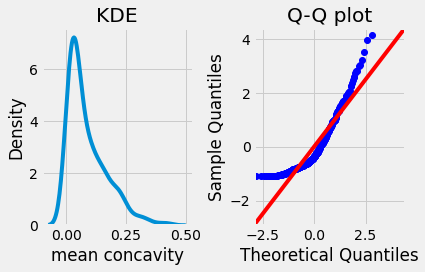

mean concave points


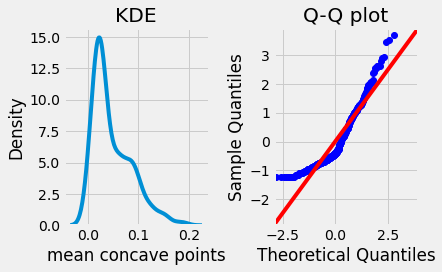

mean symmetry


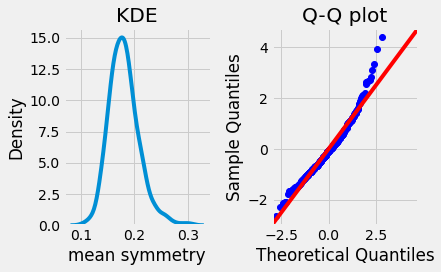

mean fractal dimension


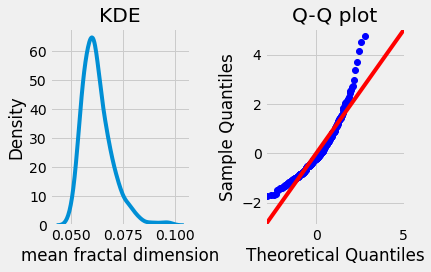

radius error


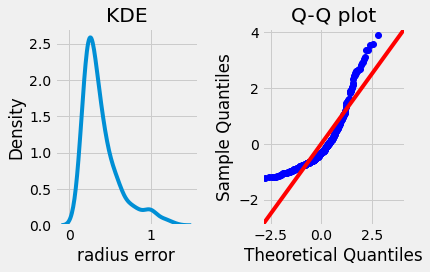

texture error


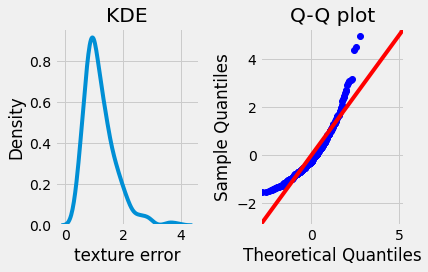

perimeter error


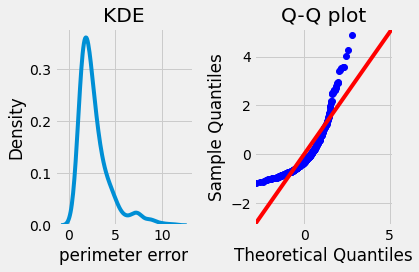

area error


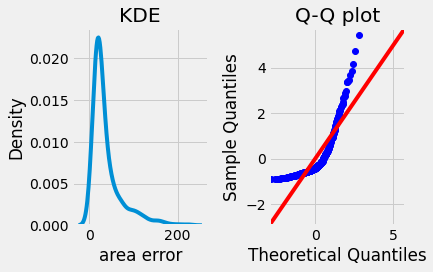

smoothness error


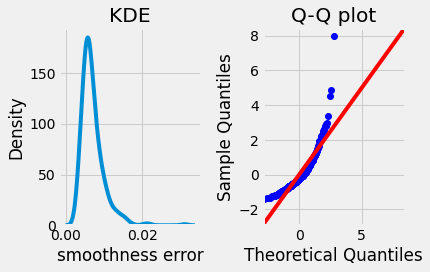

compactness error


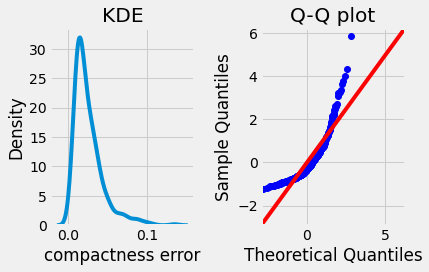

concavity error


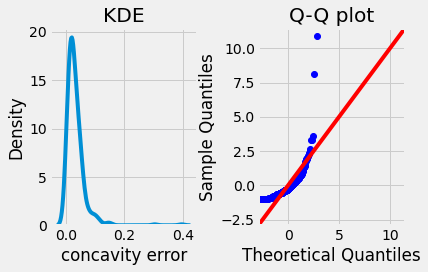

concave points error


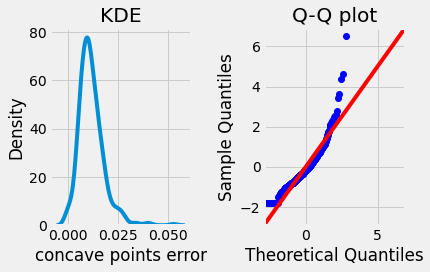

symmetry error


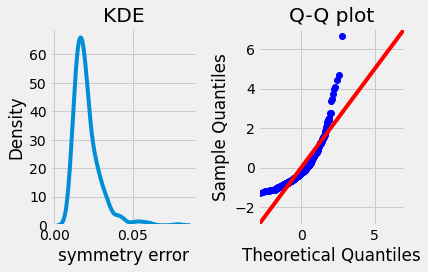

fractal dimension error


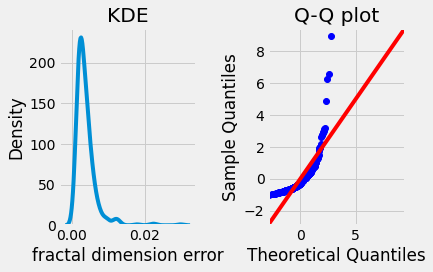

worst radius


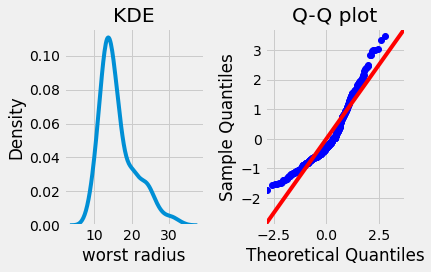

worst texture


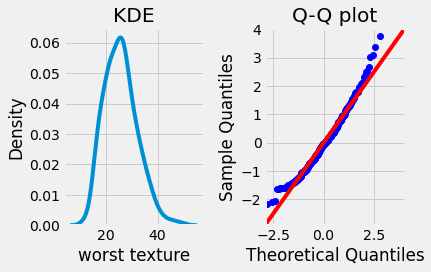

worst perimeter


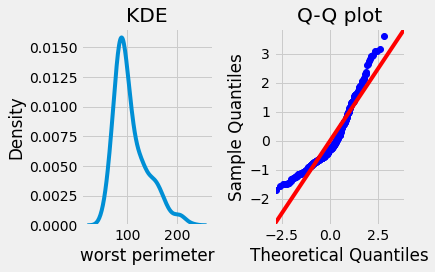

worst area


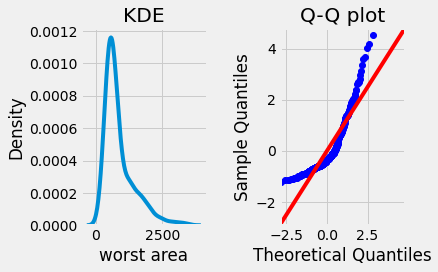

worst smoothness


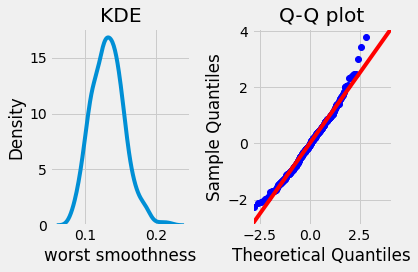

worst compactness


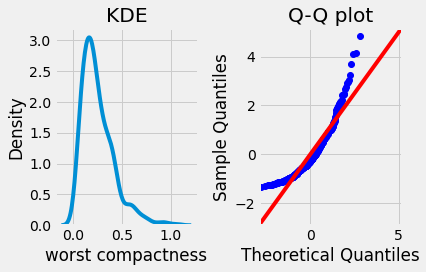

worst concavity


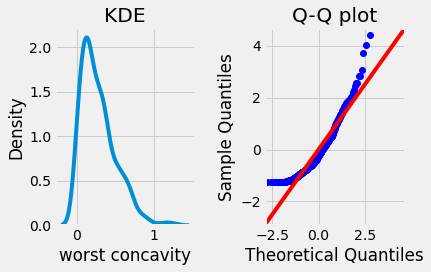

worst concave points


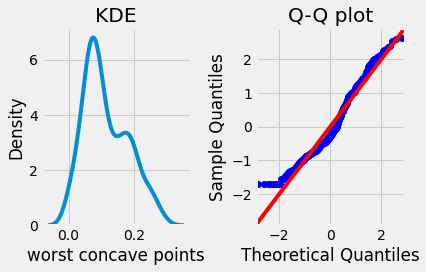

worst symmetry


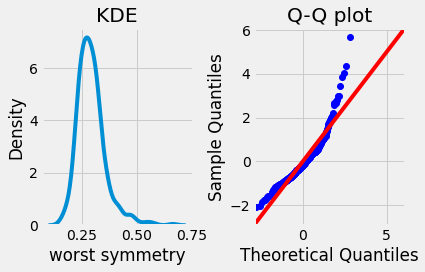

worst fractal dimension


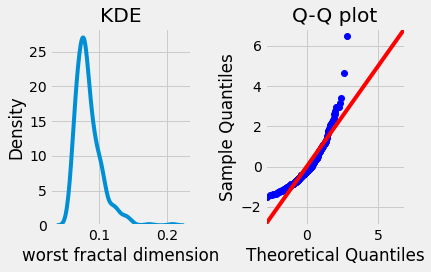

In [2]:
import statsmodels.api as sm

def plot_density(x):
    print(x.name)
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(ncols=2)
    sns.kdeplot(x, ax=ax[0])
    ax[0].set_title(f'KDE')
    sm.qqplot(x, ax=ax[1], line="45", fit=True)
    ax[1].set_title(f'Q-Q plot')
    plt.tight_layout()
    plt.show()

X_m.apply(plot_density);

Not too bad, but there are features with non-trivial depature from normality.  So, let use the scikit-learn's [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) to make them more normal.

We'll also do something weird for teaching purposes that you would not do as a working data scientist - add random noise to the features.  The reason is that GaussianNB does too well on this dataset - it makes very few errors.  You really can't see anything interesting in the PR & ROC curves if there aren't errors.  So, we add noise to force more errors.  (Like I said - you wouldn't do this in real life).

mean radius


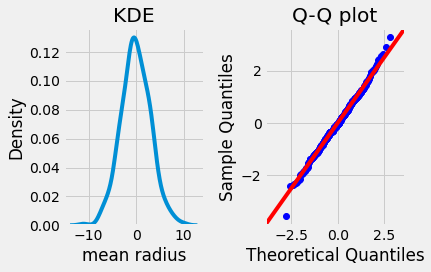

mean texture


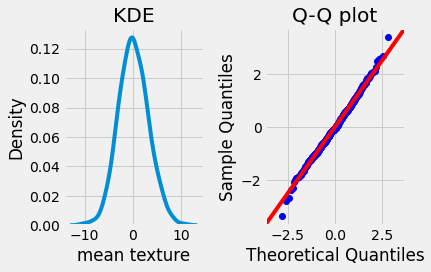

mean perimeter


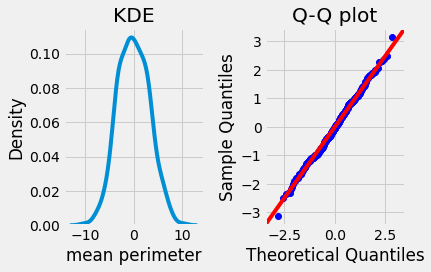

mean area


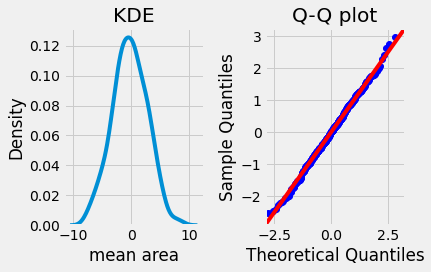

mean smoothness


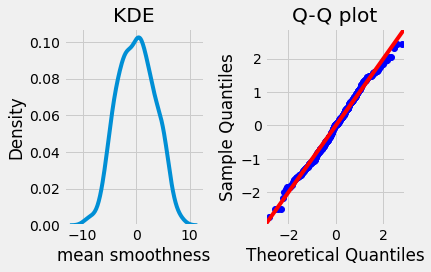

mean compactness


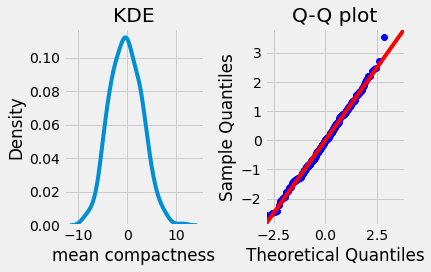

mean concavity


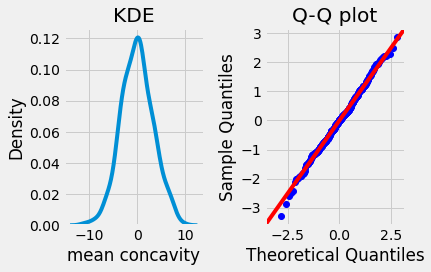

mean concave points


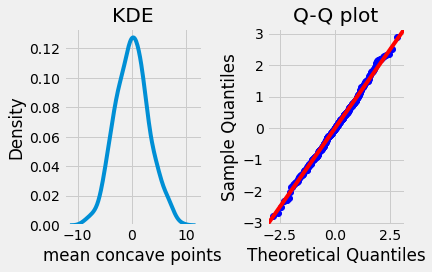

mean symmetry


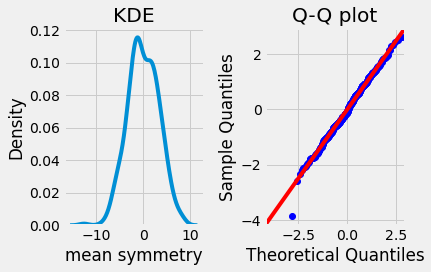

mean fractal dimension


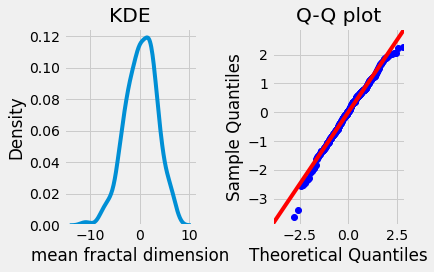

radius error


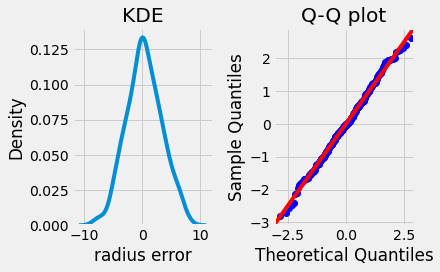

texture error


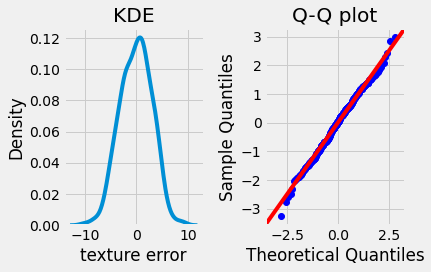

perimeter error


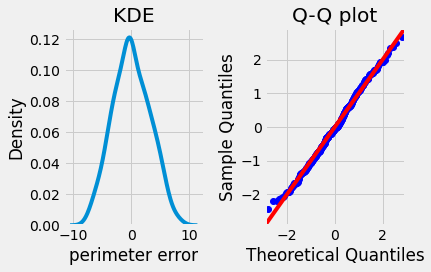

area error


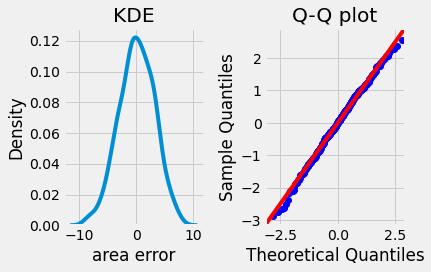

smoothness error


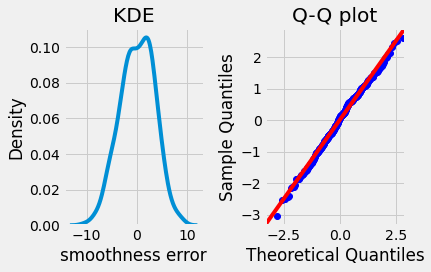

compactness error


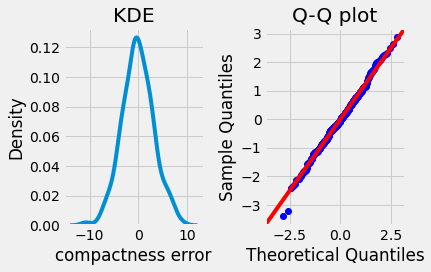

concavity error


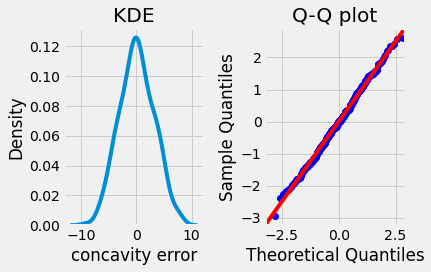

concave points error


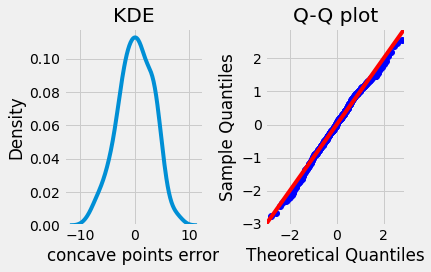

symmetry error


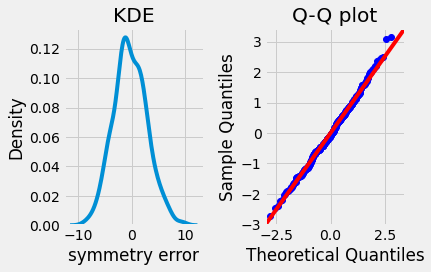

fractal dimension error


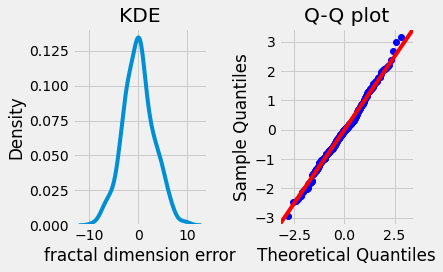

worst radius


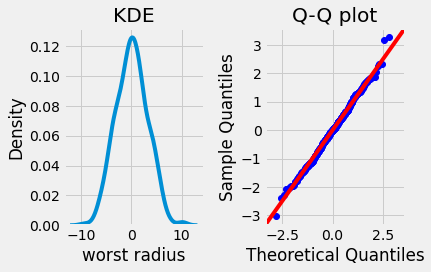

worst texture


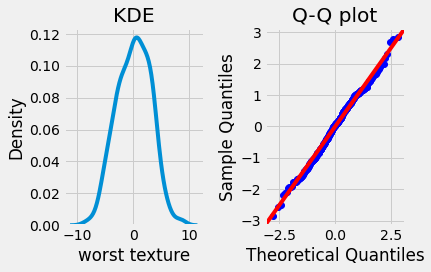

worst perimeter


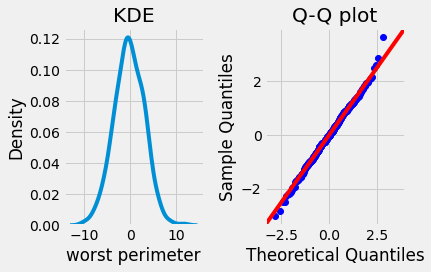

worst area


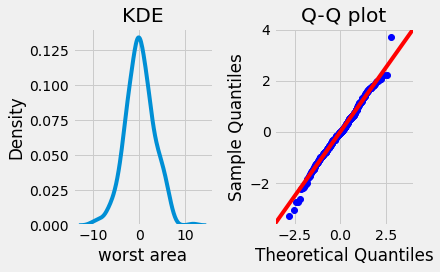

worst smoothness


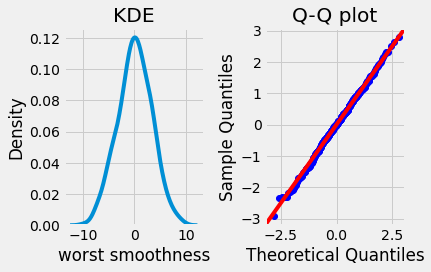

worst compactness


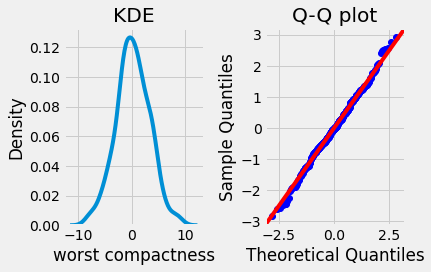

worst concavity


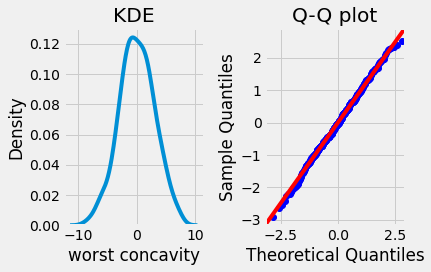

worst concave points


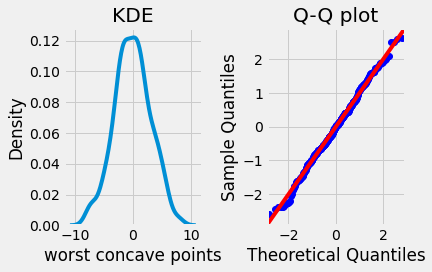

worst symmetry


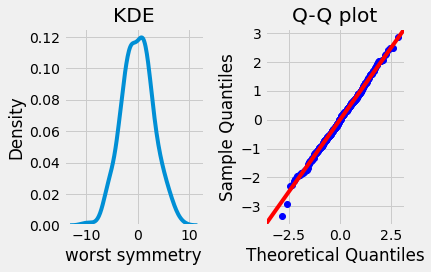

worst fractal dimension


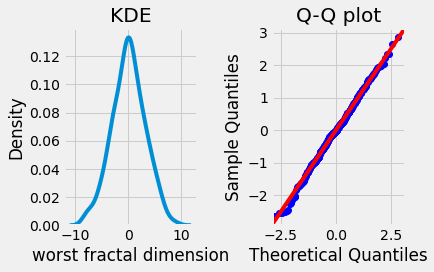

In [11]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer().fit(X_m)

def transform_add_noise(X, pt, noise=0):
    Z = pt.transform(X) + noise * rng.normal(size=X.shape)
    return pd.DataFrame(Z, columns=X.columns)

Z_m = transform_add_noise(X_m, pt, 3)
Z_h = transform_add_noise(X_h, pt, 3)
Z_m.apply(plot_density);

That's better.  Now let's use GaussianNB.

,score
0,90.21


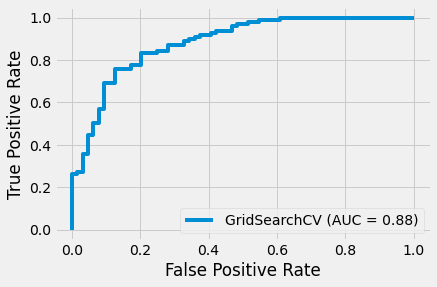

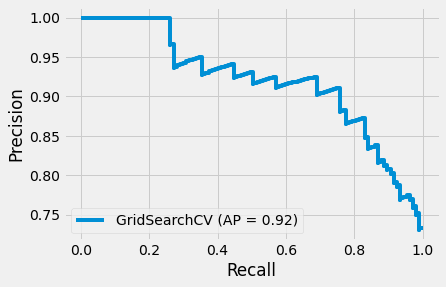

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

pipe = Pipeline([('classify', GaussianNB())])
grid = GridSearchCV(pipe, {}, cv=10, scoring='roc_auc').fit(Z_m, y_m)
display_results(grid)
plot_roc_curve(grid, Z_h, y_h)
plot_precision_recall_curve(grid, Z_h, y_h)
print()

- Both ROC & PR are parametric curves where the parameter is the threshold $p^*$.
    - Each $p^*$ produces a point (FPR, TPR) on the ROC and (Recall, Precision) on the PR
    - The curves are traced right-to-left as you vary $p^*$ from 0 to 1.
        - $p^*= 0$ means "always predict class 1, which has 100% TPR, FPR, and Recall, but 0% Precision.
        - $p^*=1$ means "never predict class 1, which has 0% TPR, FPR, and Recall, but 100% Precision.
- Area Under the Curve (AUC) is a commonly used metric that basically "averages" over $p^*$.
- Note that we used AUC as the scorer in GridSearchCV.

## MultiClass

These metrics are all geared for tasks with 2 class only.  Obviously, there are a many situations with more than 2 class.  Scikit-learn calls them "multiclass" problems.

There are 2 basic approaches:
1. Combine a bunch of 2 class metrics
    - one-v-one, one-v-rest
1. Create "natively" multiclass metrics

## Multilabel

Suppose you are looking at images and want to detect the presence of dogs, tree, and firehydrants.  Each image may contain 0, 1, 2, or 3 of these.  This is a "multilabel" task.

The "target" will have a column for each label, with T in the rows that DO contain that object (indicator variables).

Side note, [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) is very handy to convert into this form if the dataset does not come this way.